In [1]:
import os
os.environ["MKL_SERVICE_FORCE_INTEL"] = "1"

import numpy as np
from astropy.table import Table
from matplotlib import pyplot as plt
%matplotlib inline

homedir=os.getenv("HOME")

dat_path = homedir+'/Desktop/wisesize/'

In [4]:
wisetab = Table.read(dat_path+'a100-nsa-for-adap.fits')

### First task -- Reproduce Galaxy Selection from Proposal
#### 0.002<z<0.025, SNR(NUV) or SNR(W3)>20, r-band R$_e$ > 5.5" (will instead use 6.5")

In [5]:
#define W3 and GALEX (NUV) SNR:
w3_flux = wisetab['w3_nanomaggies']
w3_ivar = wisetab['w3_nanomaggies_ivar']     #1/sig^2
w3_snr = w3_flux * np.sqrt(w3_ivar)
w3_snr_col = wisetab['W3SNR']

galex_flux = wisetab['NMGY'][:,1]   #supposedly corresponds to NUV flux in nanomaggies (nmgy)
galex_ivar = wisetab['NMGY_IVAR'][:,1] 
NUV_snr = galex_flux * np.sqrt(galex_ivar)

In [56]:
#SNR>20. cut
snr_flag = ((w3_snr>20.) | (w3_snr_col>20.)) | (NUV_snr>20.)
snr_flag10 = ((w3_snr>10.) | (w3_snr_col>10.)) | (NUV_snr>10.)

In [58]:
zflag & re_flag & snr_flag
wise_flagtab = Table([wisetab['IAUNAME'],wisetab['RA'],wisetab['DEC'],zflag,snr_flag,
                      snr_flag10,re_flag,re_flag_55],
                     names=['IAUNAME','RA','DEC','zflag','snrflag_20',
                            'snrflag_10','re_flag65','re_flag55'])

In [51]:
#r-band Re > 6.5" cut   (change to 5.5" to exactly replicate proposal values)
re_1 = wisetab['SERSIC_TH50']
re_2 = wisetab['petroR50_r']
re_flag = (re_1>6.5) | (re_2>6.5)
re_flag_55 = (re_1>5.5) | (re_2>5.5)

#### Generating Flag Table

In [30]:
#redshift 0.002<z<0.025 cut
zmin=0.002
zmax=0.025

z = wisetab['ZDIST']
vhelio = wisetab['Vhelio']
z_flag = (z>zmin) & (z<zmax)
vhelioflag = (vhelio>(zmin*3e5)) & (vhelio<(zmax*3e5))
zflag = z_flag | vhelioflag   #use both as a "check"

In [59]:
wise_flagtab.write(homedir+'/Desktop/wisesize/WISESize_flags_v1.fits',overwrite=True)

#### RA v. DEC

In [31]:
proposal_sample = wisetab[zflag & re_flag & snr_flag]

In [32]:
ra = proposal_sample['RA']
dec = proposal_sample['DEC']
z = proposal_sample['ZDIST']

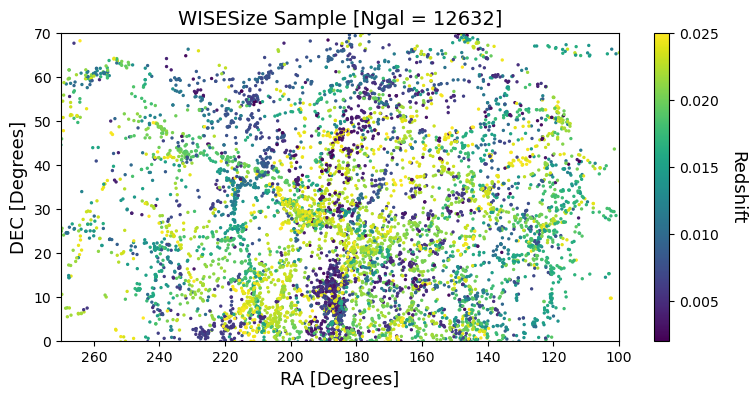

In [50]:
plt.figure(figsize=(9,4))
plt.scatter(ra,dec,c=z,s=2)
plt.xlim(270,100)
plt.ylim(0,70)
plt.clim(0.002,0.025)
cbar = plt.colorbar()
cbar.set_label('Redshift',fontsize=13,rotation=270,labelpad=20)
plt.xlabel('RA [Degrees]',fontsize=13)
plt.ylabel('DEC [Degrees]',fontsize=13)
plt.title(f'WISESize Sample [Ngal = {len(proposal_sample)}]',fontsize=14)
plt.show()

---

### NED-LVS 

In [60]:
ned_sample = Table.read(homedir+'/Downloads/NEDLVS_20210922_v2.fits')

In [65]:
redshift_flag = (ned_sample['z']>0.002) & (ned_sample['z']<0.025)
ra_flag = (ned_sample['ra']>100.) & (ned_sample['ra']<270.)
dec_flag = (ned_sample['z']>0.) & (ned_sample['z']<70.)

In [69]:
cut_ned_sample = ned_sample[redshift_flag&ra_flag&dec_flag]
print(len(cut_ned_sample))

50503


In [140]:
gpair_flag = (cut_ned_sample['objtype']=='GPair')

In [142]:
cut_ned_sample = cut_ned_sample[~gpair_flag]

In [146]:
print(len(cut_ned_sample))

50031


In [144]:
#cut_ned_sample.write(homedir+'/Desktop/wisesize/LVS_samplecut_nogpair.fits',overwrite=True)

Using TOPCAT, I then compared this table with the full z0MGS. Using RA, DEC and a max error of 2", I found 8002 matches in the case where GPair galaxies are retained and 7997 matches when GPair galaxies are removed.

In [148]:
lvs_z0mgs = Table.read(homedir+'/Desktop/wisesize/z0mgs_LVS_matches_nogpair.fits')

Create z0mgs flag for LVS galaxies:

In [149]:
objname_matches = []
for obj in lvs_z0mgs['objname']:
    objname_matches.append(obj.strip())

In [150]:
z0mgs_match_flag = np.zeros(len(cut_ned_sample),dtype='bool')

for i in range(len(cut_ned_sample)):
    obj = cut_ned_sample['objname'][i].strip()
    if obj in objname_matches:
        z0mgs_match_flag[i] = True
    else:
        z0mgs_match_flag[i] = False

In [151]:
len(cut_ned_sample[z0mgs_match_flag])

7997

In [154]:
#cut_ned_sample[~z0mgs_match_flag].write(homedir+'/Desktop/wisesize/LVS_sample_noz0MGS_nogpair.fits')

Of the galaxies with no z0mgs matches, when compared with SGA-2020 I found 15257 matches (again used RA, DEC with a max error of 2") if gpairs are retained and 15238 matches if removed.

In [155]:
lvs_sga = Table.read(homedir+'/Desktop/wisesize/SGA2020_LVS_matches_nogpair.fits')

In [156]:
objname_matches = []
for obj in lvs_sga['objname']:
    objname_matches.append(obj.strip())

In [157]:
sga2020_match_flag = np.zeros(len(cut_ned_sample),dtype='bool')

for i in range(len(cut_ned_sample)):
    obj = cut_ned_sample['objname'][i].strip()
    if obj in objname_matches:
        sga2020_match_flag[i] = True
    else:
        sga2020_match_flag[i] = False

In [158]:
len(cut_ned_sample[sga2020_match_flag])

15238

In [159]:
print(f'Number of galaxies unspoken for: {len(cut_ned_sample[~sga2020_match_flag & ~z0mgs_match_flag])}')

Number of galaxies unspoken for: 26796


---